In [1]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
import pickle

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mila/p/penmet

In [17]:
# Choose file
# 4 rooms (option 1)
with open('../storage/5b-main-generalization-all-baselines.p', 'rb') as f:
    rewards = pickle.load(f)
rewards2 = pickle.load( open( "../storage/9-plots.p", "rb" ) )
# 3 rooms (option 1)

# 3 rooms (option 2)
# 3 rooms (option 21)

In [24]:
print(rewards.keys(),rewards2.keys())
rewards_new = {'DQN h=(16,)- 2708 parameters': rewards['baseline: DQN, h=(16,): 2788 learnable params'],
               'DQN h=(676,) - 117628 parameters': rewards2['DQN no shuffle layer 1 weights, fine tuning 0 init fc layer'],
               'DQN h=(676,) - 2708 parameters': rewards2['DQN shuffled layer 1 weights, fine tuning 0 init fc layer'],
              'AVSF($\pi_{good}$) - 169 parameters': rewards['avDSR, 0.8eps, 4DQNs: 169 learnable params (3e5 training)'],
              'AVSF($\pi_{good}$) - 2708 parameters': rewards['avDSR, 0.8eps, 4DQNs: 2708 learnable params (3e5 training)'],
              'AVSF($\pi_{\epsilon=1}$) - 169 parameters': rewards['avDSR, 1eps: 169 learnable params (3e5 training)'],
              'AVSF($\pi_{\epsilon=1}$) - 2708 parameters': rewards['avDSR, 1eps: 2708 learnable params (23e5 training)'],}

dict_keys(['baseline: DQN, h=(16,): 2788 learnable params', 'baseline: DQN, h=(400,): ~70000 learnable params', 'baseline: DQN, h=(676,): 2708 learnable params (lay1 fixed)', 'avDSR, 0.8eps, 4DQNs: 169 learnable params (3e5 training)', 'avDSR, 0.8eps, 4DQNs: 2708 learnable params (3e5 training)', 'avDSR, 1eps: 169 learnable params (3e5 training)', 'avDSR, 1eps: 2708 learnable params (23e5 training)']) dict_keys(['DQN no shuffle layer 1 weights, fine tuning 0 init fc layer', 'DQN shuffled layer 1 weights, fine tuning 0 init fc layer'])


In [29]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 5000
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#ec7603', '#34495e', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
#                 plt.plot(t, r, label=k)
                plt.plot(convolve(np.interp(np.arange(clip), t, r), smooth),label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, alpha=0.3, color=colors[j])
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

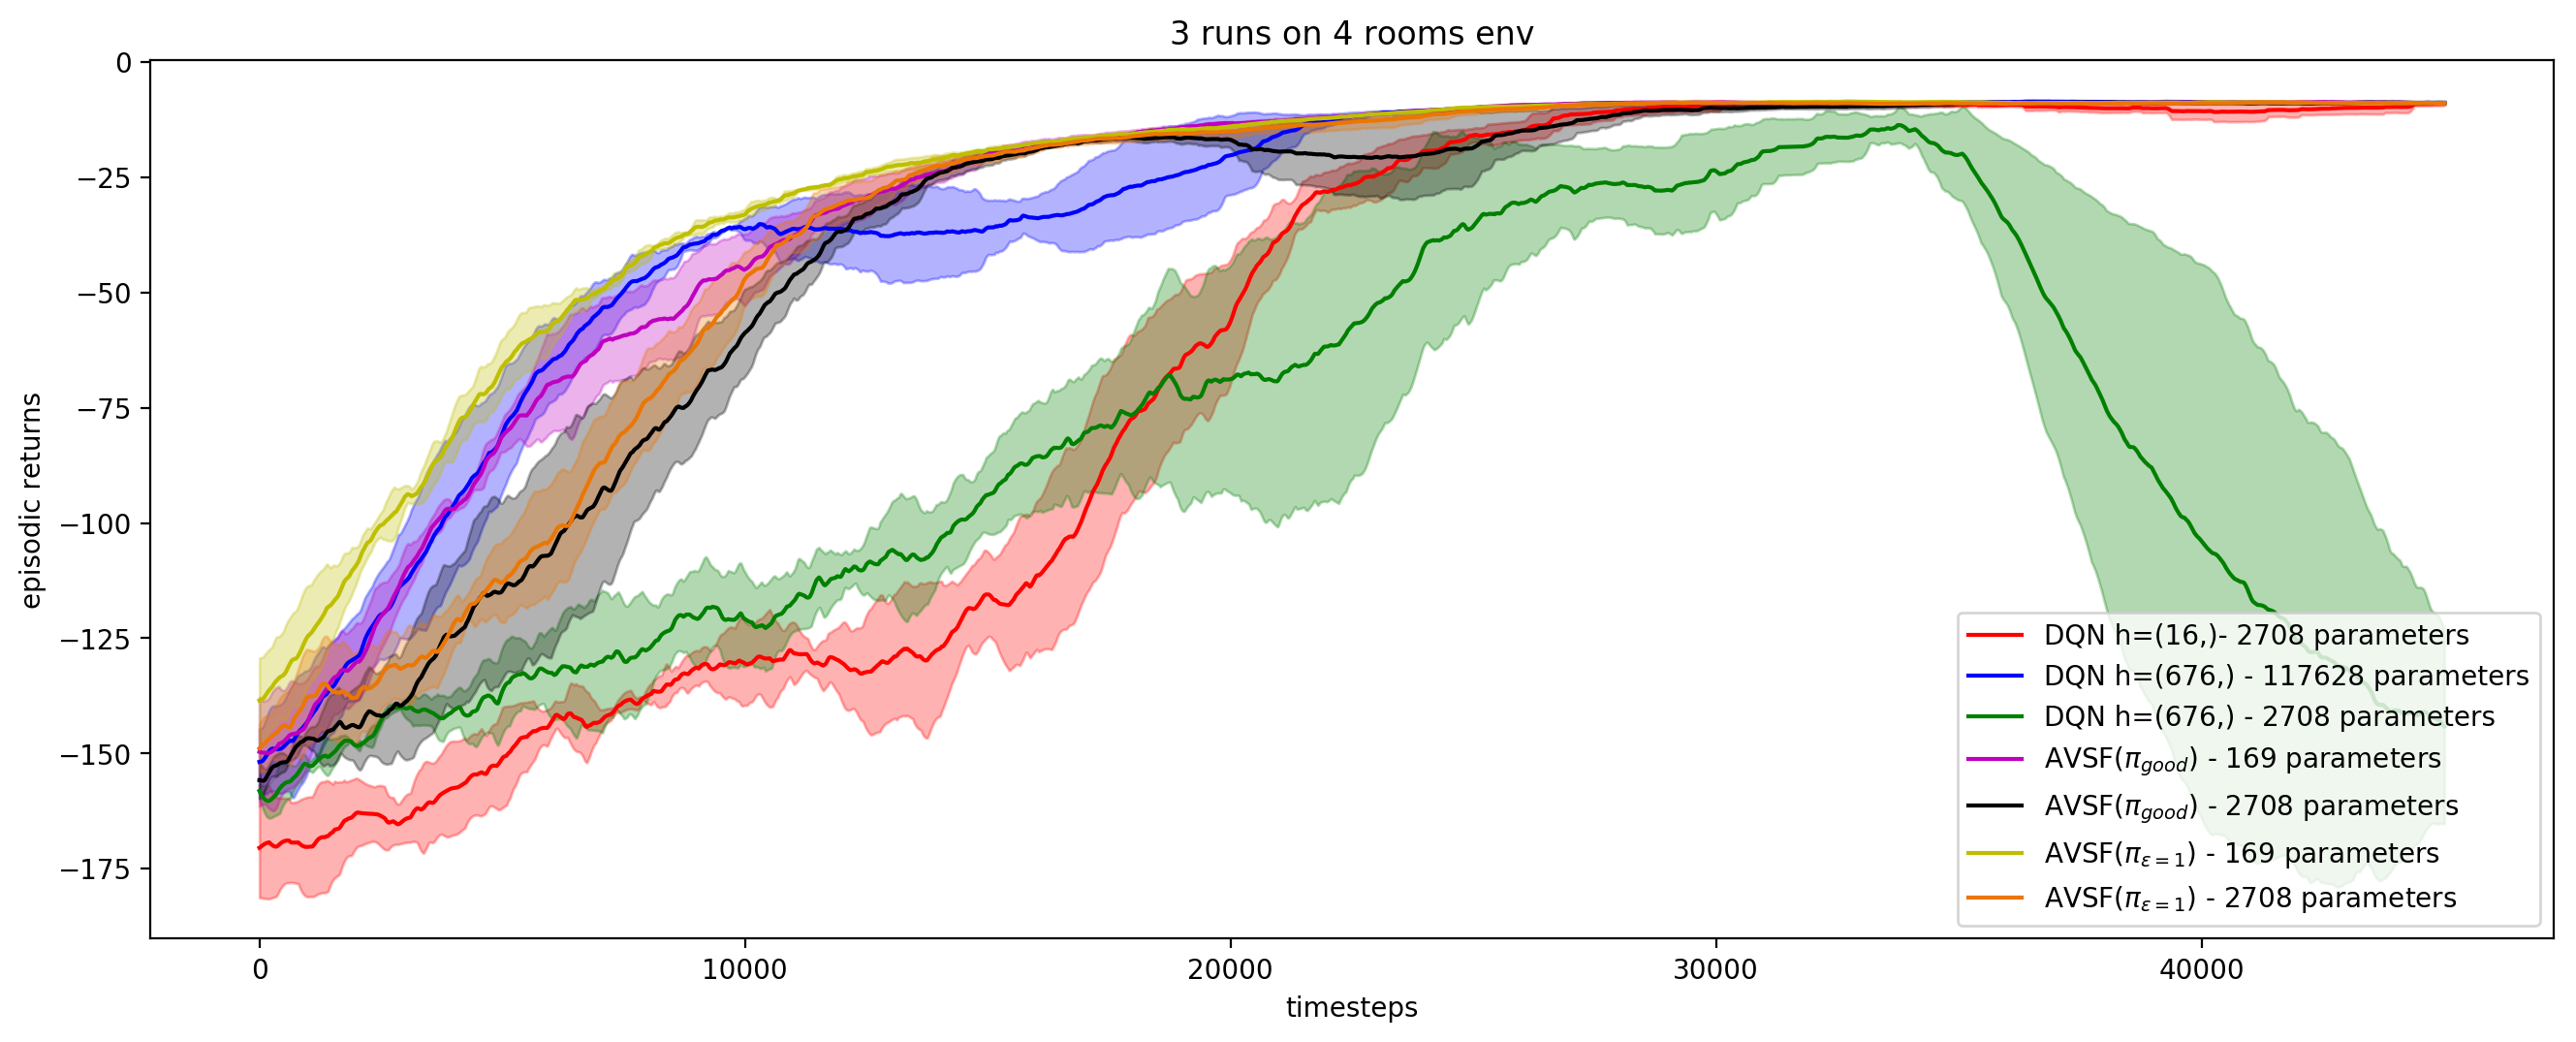

In [30]:
plot_rewards(rewards_new, plot_seperate=False, title='3 runs on 4 rooms env')
# plot_rewards(rewards2, plot_seperate=True, title='3 runs on 4 rooms env')

In [33]:
with open('../storage/34-rewards-4rooms.pickle', 'wb') as f:
    pickle.dump(rewards_new, f, pickle.HIGHEST_PROTOCOL)

In [4]:
count = 0
r_vec_169 = []
r_vec_2708 = []
for key, vals in rewards.items():
#     import pdb; pdb.set_trace()
    if('169' in key):
        avr = np.mean([np.mean(vals[1][0]), np.mean(vals[1][1]), np.mean(vals[1][2])])
        r_vec_169.append(avr)
    if('2708' in key):
        avr = np.mean([np.mean(vals[1][0]), np.mean(vals[1][1]), np.mean(vals[1][2])])
        r_vec_2708.append(avr)
        

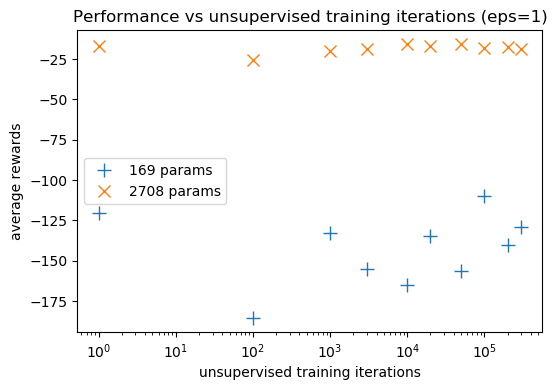

(<matplotlib.legend.Legend at 0x7ff2f06c80b8>, None)

In [5]:
iters2 = [i+1 for i in iters]
plt.figure(figsize=(6,4),dpi=100)
plt.semilogx(iters2, r_vec_169, '+', label='169 params',markersize=10)
plt.semilogx(iters2, r_vec_2708, 'x', label='2708 params', markersize=8)
plt.ylabel('average rewards'), plt.xlabel('unsupervised training iterations')
plt.title('Performance vs unsupervised training iterations (eps=1)')
plt.legend(), plt.show()

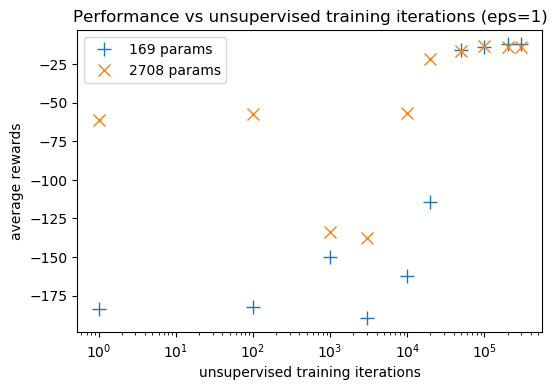

(<matplotlib.legend.Legend at 0x7fd04e50acf8>, None)

In [150]:
iters2 = [i+1 for i in iters]
plt.figure(figsize=(6,4),dpi=100)
plt.semilogx(iters2, r_vec_169, '+', label='169 params',markersize=10)
plt.semilogx(iters2, r_vec_2708, 'x', label='2708 params', markersize=8)
plt.ylabel('average rewards'), plt.xlabel('unsupervised training iterations')
plt.title('Performance vs unsupervised training iterations (eps=1)')
plt.legend(), plt.show()

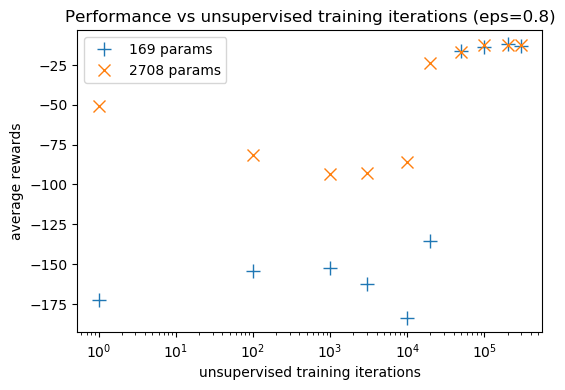

(<matplotlib.legend.Legend at 0x7fd04e4dbcf8>, None)

In [140]:
iters2 = [i+1 for i in iters]
plt.figure(figsize=(6,4),dpi=100)
plt.semilogx(iters2, r_vec_169, '+', label='169 params',markersize=10)
plt.semilogx(iters2, r_vec_2708, 'x', label='2708 params', markersize=8)
plt.ylabel('average rewards'), plt.xlabel('unsupervised training iterations')
plt.title('Performance vs unsupervised training iterations (eps=0.8)')
plt.legend(), plt.show()

In [155]:
### Plotting option 1 and option2 results

In [163]:
rewards = {}
iters = [3e5]
for i in iters:
    with open('../storage/21-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
        rewards2 = pickle.load(f)
        
for i in iters:
    with open('../storage/18-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
        rewards = pickle.load(f)

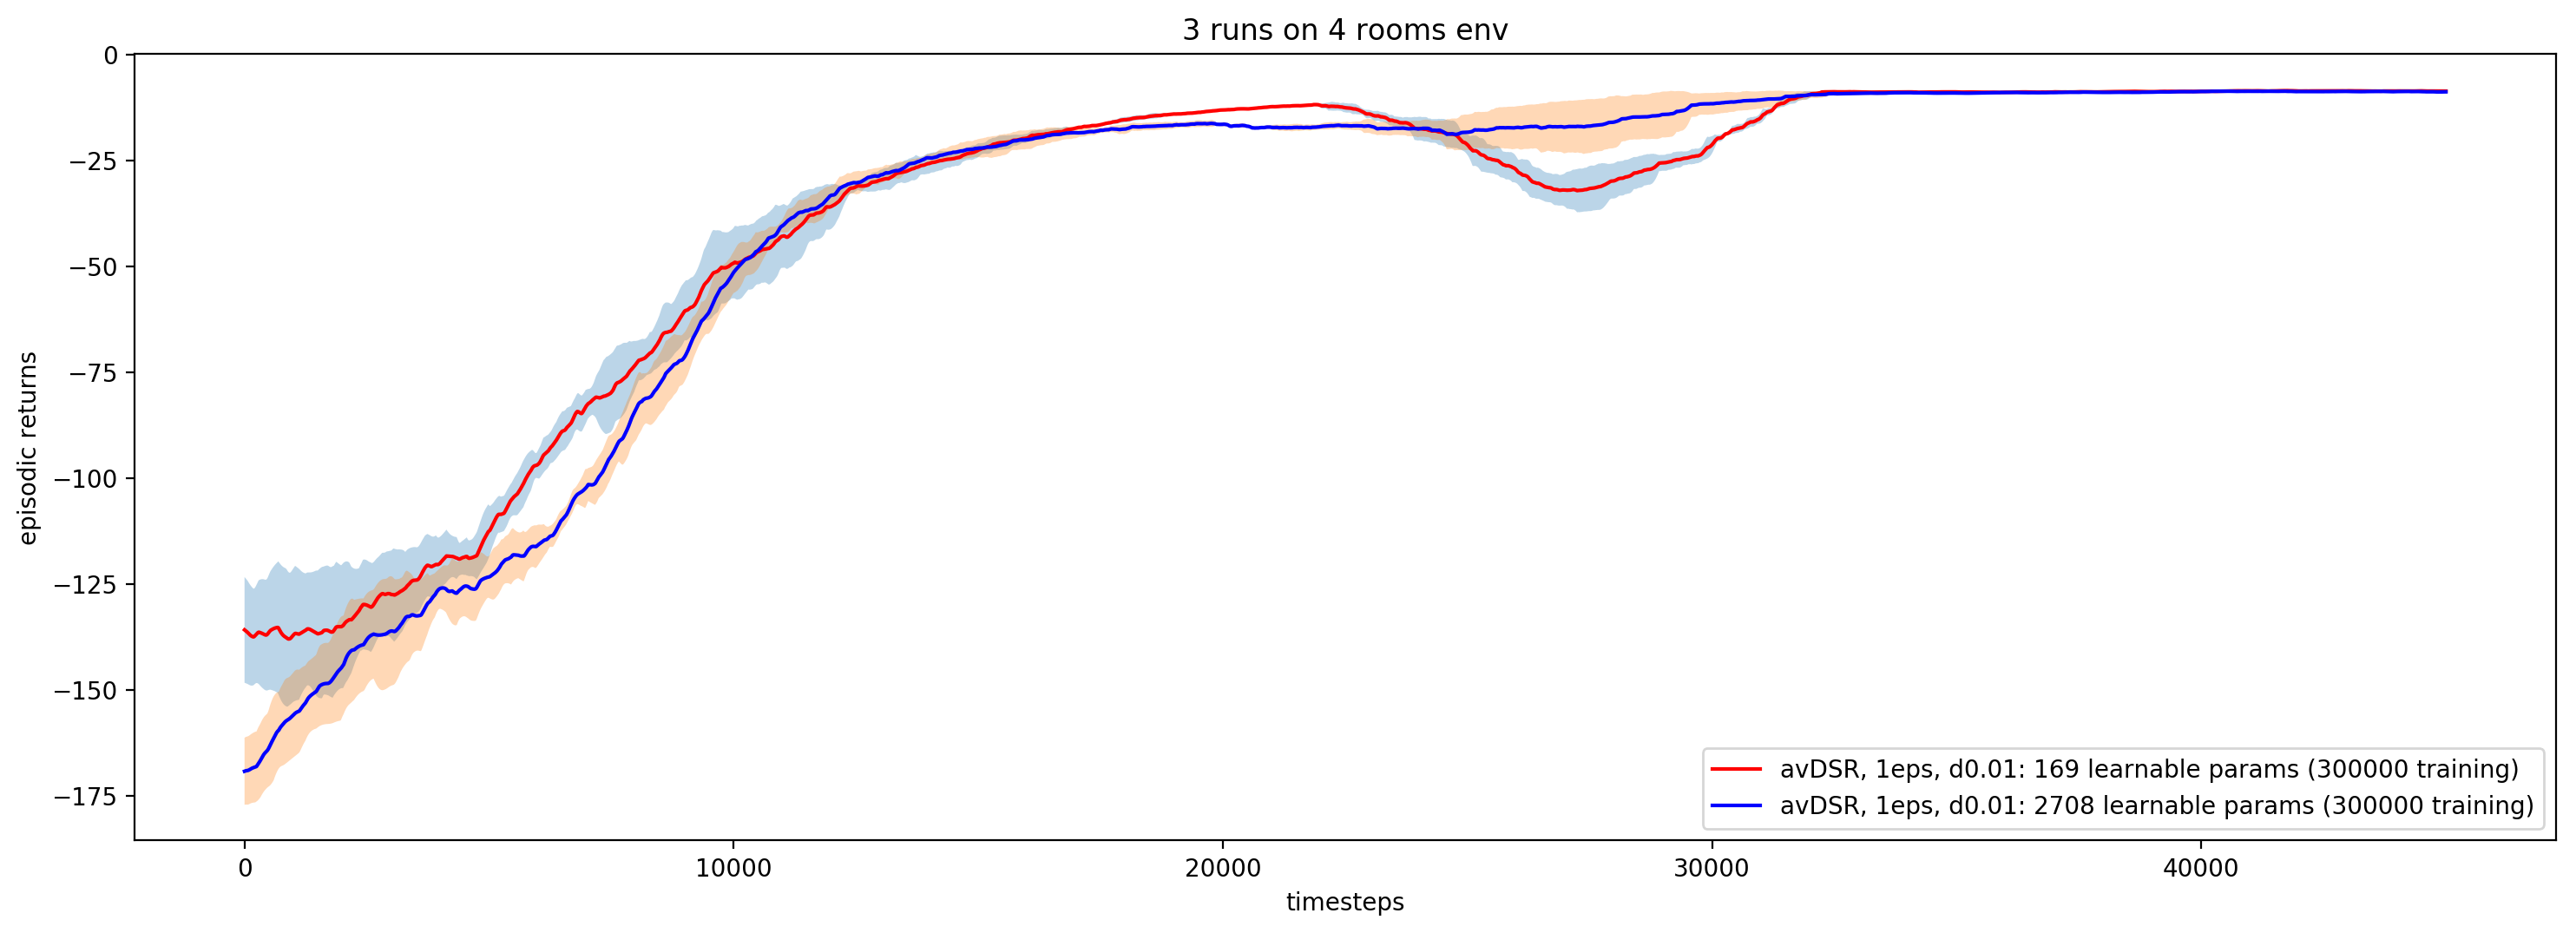

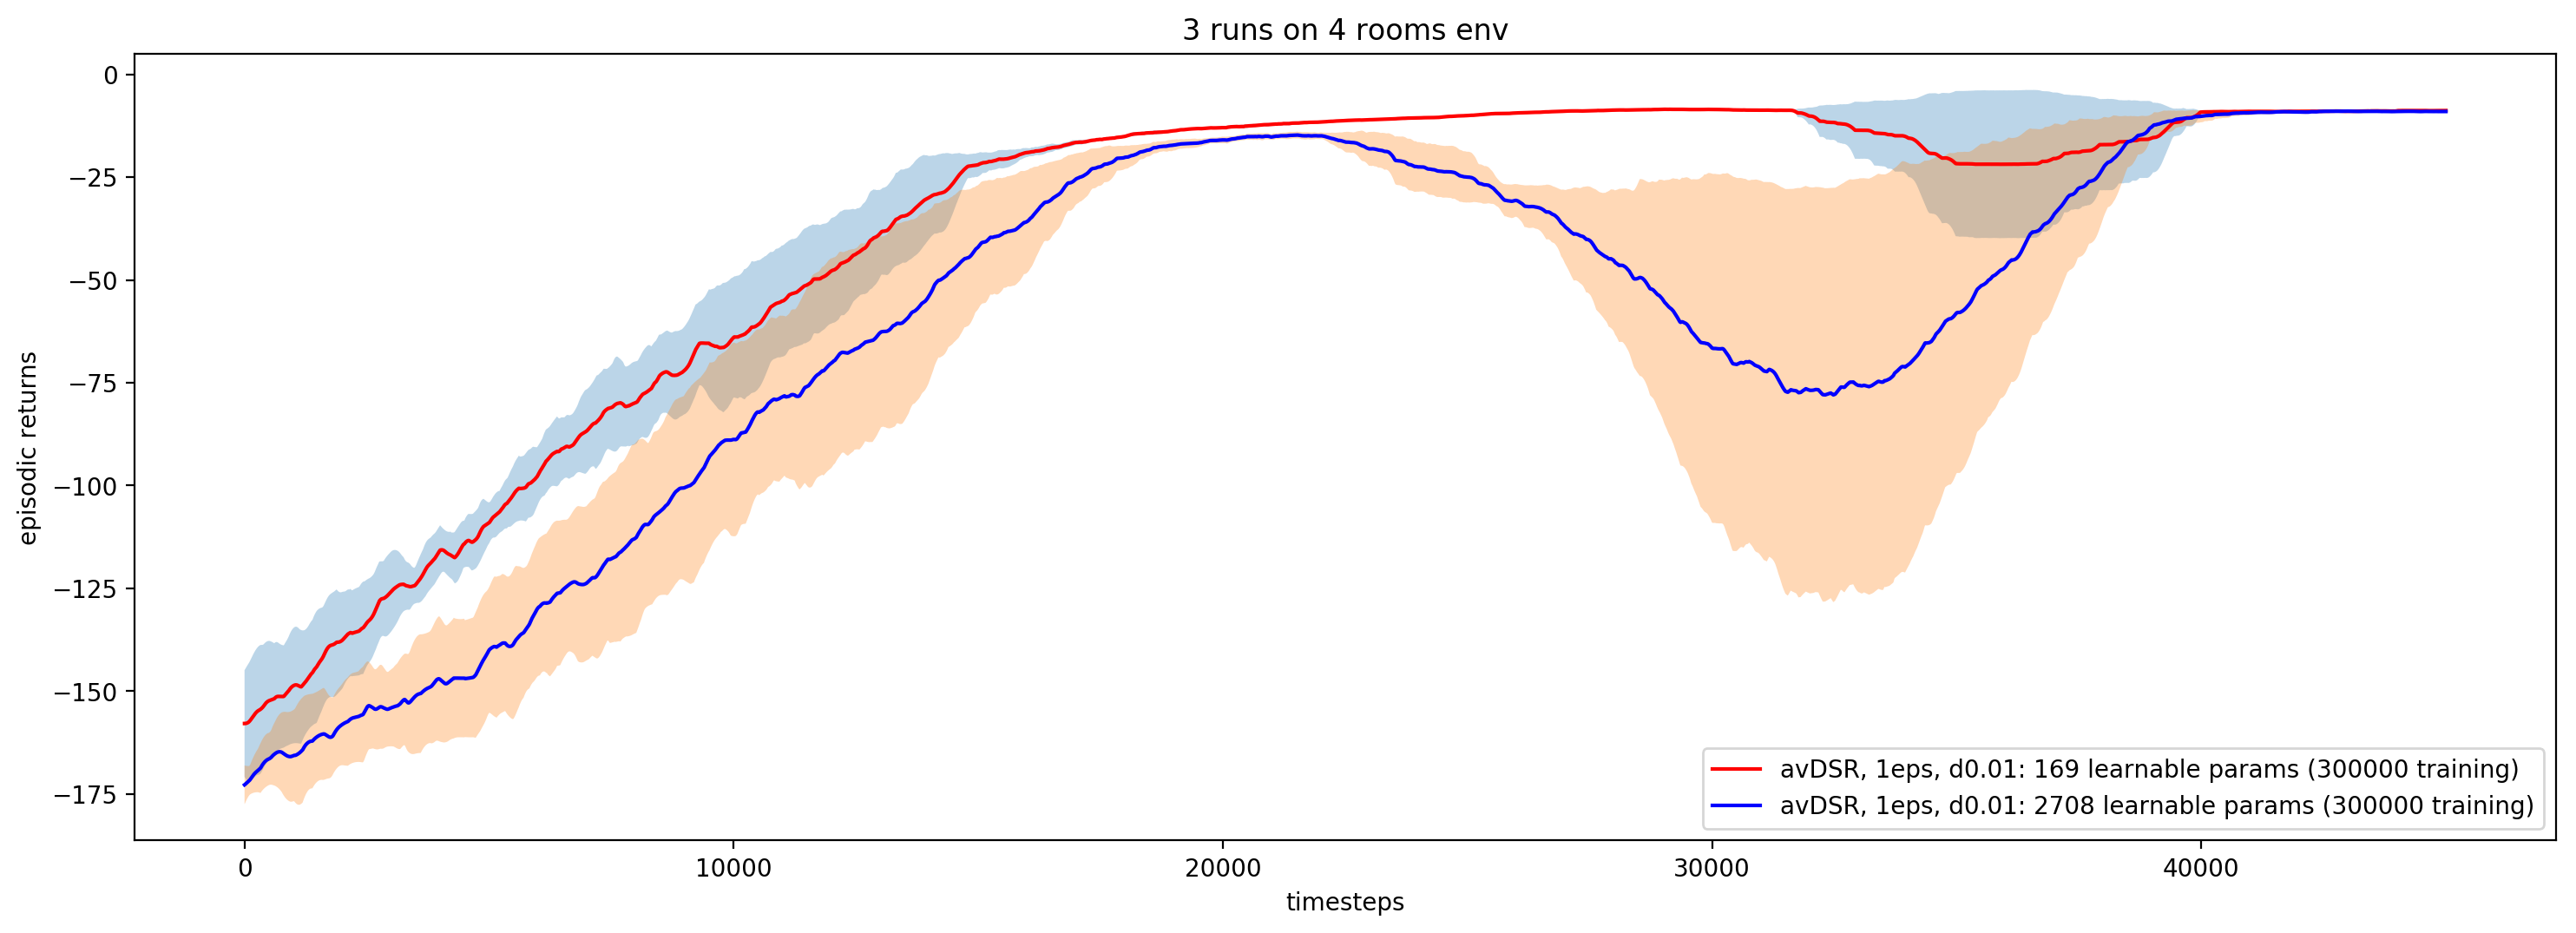

In [164]:
plot_rewards(rewards, plot_seperate=False, title='3 runs on 4 rooms env')
plot_rewards(rewards2, plot_seperate=False, title='3 runs on 4 rooms env')

In [3]:
all_rewards = {}
iters = [1e2, 1e3, 3e3, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5]
# iters = [0]
for i in iters:
    with open('../storage/27-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
        rewards = pickle.load(f)
        
        for key, val in rewards.items():
            if('169' in key):
                all_rewards[str(int(i))+'-169'] = val
            elif('2708' in key):
                all_rewards[str(int(i))+'-2708'] = val
            else:
                raise
        

In [4]:
all_rewards.keys()

dict_keys(['100-169', '100-2708', '1000-169', '1000-2708', '3000-169', '3000-2708', '10000-169', '10000-2708', '20000-169', '20000-2708', '50000-169', '50000-2708', '100000-169', '100000-2708', '200000-169', '200000-2708', '300000-169', '300000-2708'])

In [7]:
all_rewards = {}
iters = [1e2, 1e3, 3e3, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5]
# iters = [0]
for i in iters:
    with open('../storage/28-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
        rewards = pickle.load(f)
        
        for key, val in rewards.items():
            if('169' in key):
                all_rewards[str(int(i))+'-169'] = val
            elif('2708' in key):
                all_rewards[str(int(i))+'-2708'] = val
            else:
                raise

all_rewards2 = {}
iters = [1e2, 1e3, 3e3, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5]
# iters = [0]
for i in iters:
    with open('../storage/28-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
        rewards = pickle.load(f)
        
        for key, val in rewards.items():
            if('169' in key):
                all_rewards2[str(int(i))+'-169'] = val
            elif('2708' in key):
                all_rewards2[str(int(i))+'-2708'] = val
            else:
                raise

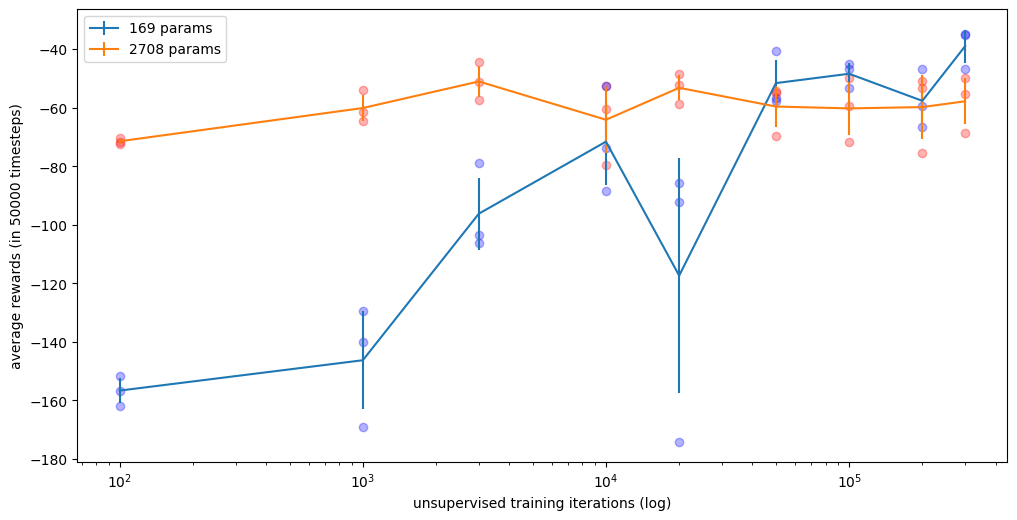

(<matplotlib.legend.Legend at 0x7fddbdfa6630>, None)

In [9]:
plt.figure(figsize=(12,6),dpi=100)
clip = 50000
smooth = 1000
line1 = []
line1_std = []
line2 = []
line2_std = []
for j, (k, v) in enumerate(all_rewards.items()):
    ind = k.split('-')
    r_vec = np.zeros((len(v[0]), 50000-smooth+1))
    for i, (t, r) in enumerate(zip(v[0], v[1])):
        r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)

    mean = np.mean(np.array(r_vec), axis=1)
    std = np.std(mean)
    if(ind[1]=='169'):
        line1.append(mean)
        line1_std.append(std)
    if(ind[1]=='2708'):
        line2.append(mean)
        line2_std.append(std)

line1 = np.array(line1)
line2 = np.array(line2)
# import pdb;pdb.set_trace()
plt.errorbar(iters, np.mean(line1,axis=1), line1_std, label='169 params')
plt.errorbar(iters, np.mean(line2,axis=1), line2_std,label='2708 params')
for i in range(line1.shape[1]):
    plt.scatter(iters, line1[:,i], c='b', alpha=0.3)
    plt.scatter(iters, line2[:,i], c='r', alpha=0.3)

plt.xscale('log')
plt.xlabel('unsupervised training iterations (log)'), plt.ylabel('average rewards (in 50000 timesteps)')
# plt.title(title)
plt.legend(), plt.show()

In [ ]:
plt.figure(figsize=(12,6),dpi=100)
clip = 50000
smooth = 1000
line1 = []
line1_std = []
line2 = []
line2_std = []
for j, (k, v) in enumerate(all_rewards.items()):
    ind = k.split('-')
    r_vec = np.zeros((len(v[0]), 50000-smooth+1))
    for i, (t, r) in enumerate(zip(v[0], v[1])):
        r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)

    mean = np.mean(np.array(r_vec), axis=1)
    std = np.std(mean)
    if(ind[1]=='169'):
        line1.append(mean)
        line1_std.append(std)
    if(ind[1]=='2708'):
        line2.append(mean)
        line2_std.append(std)

line1 = np.array(line1)
line2 = np.array(line2)
# import pdb;pdb.set_trace()
plt.errorbar(iters, np.mean(line1,axis=1), line1_std, label='169 params')
plt.errorbar(iters, np.mean(line2,axis=1), line2_std,label='2708 params')
for i in range(line1.shape[1]):
    plt.scatter(iters, line1[:,i], c='b', alpha=0.3)
    plt.scatter(iters, line2[:,i], c='r', alpha=0.3)

plt.xscale('log')
plt.xlabel('unsupervised training iterations (log)'), plt.ylabel('average rewards (in 50000 timesteps)')
# plt.title(title)
plt.legend(), plt.show()

In [13]:
def plot_performance(file_index='14', title='unnamed'):
    all_rewards = {}
    iters = [1e2, 1e3, 3e3, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5]
    # iters = [0]
    for i in iters:
        with open('../storage/'+file_index+'-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
            rewards = pickle.load(f)

            for key, val in rewards.items():
                if('169' in key):
                    all_rewards[str(int(i))+'-169'] = val
                elif('2708' in key):
                    all_rewards[str(int(i))+'-2708'] = val
                else:
                    raise
                    
    plt.figure(figsize=(12,6),dpi=100)
    clip = 50000
    smooth = 1000
    line1 = []
    line1_std = []
    line2 = []
    line2_std = []
    for j, (k, v) in enumerate(all_rewards.items()):
        ind = k.split('-')
        r_vec = np.zeros((len(v[0]), 50000-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)

        mean = np.mean(np.array(r_vec), axis=1)
        std = np.std(mean)
        if(ind[1]=='169'):
            line1.append(mean)
            line1_std.append(std)
        if(ind[1]=='2708'):
            line2.append(mean)
            line2_std.append(std)

    line1 = np.array(line1)
    line2 = np.array(line2)
    # import pdb;pdb.set_trace()
    plt.errorbar(iters, np.mean(line1,axis=1), line1_std, label='169 params')
    plt.errorbar(iters, np.mean(line2,axis=1), line2_std,label='2708 params')
    for i in range(line1.shape[1]):
        plt.scatter(iters, line1[:,i], c='b', alpha=0.3)
        plt.scatter(iters, line2[:,i], c='r', alpha=0.3)

    plt.xscale('log')
    plt.xlabel('unsupervised training iterations (log)'), plt.ylabel('average rewards (in 50000 timesteps)')
    plt.title(title)
    plt.legend(), plt.show()

<Figure size 1200x600 with 0 Axes>

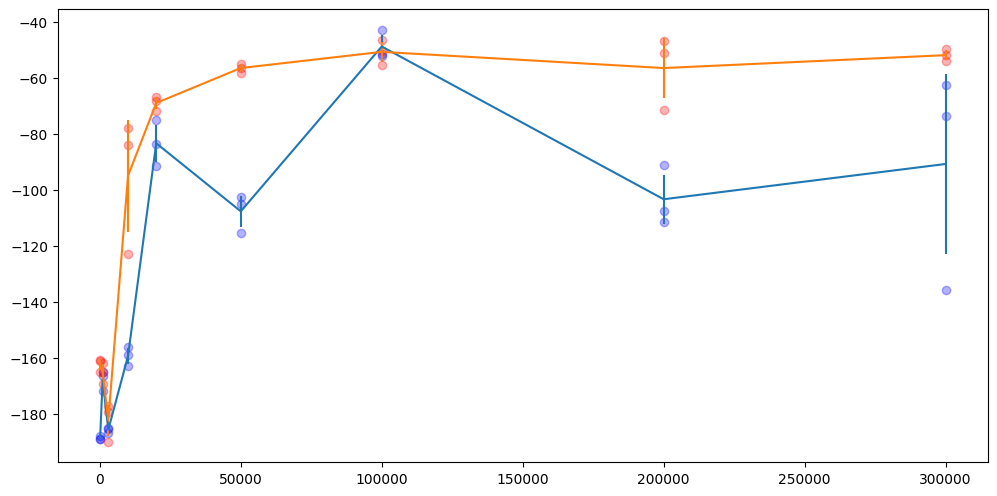

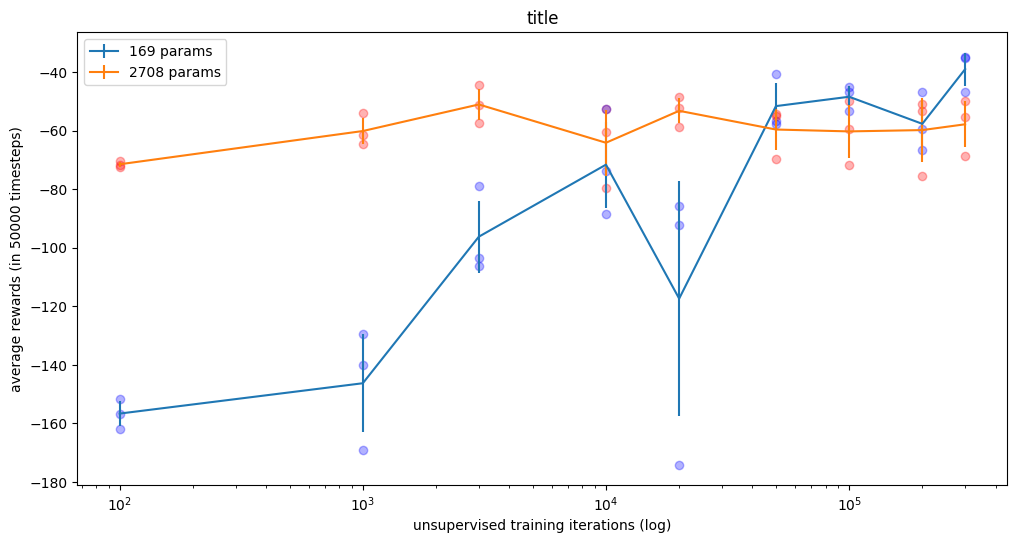

(<matplotlib.legend.Legend at 0x7fddbd366588>, None)

In [16]:
plot_performance(file_index='14', title='Training APSF on 4rooms')
plot_performance(file_index='30', title='Training APSF on 3roomsh')
plot_performance(file_index='27', title='Training APSF on [3rooms,3roomsh,4rooms]')
plot_performance(file_index='28', title='Training APSF on [3roomsh] with [3rooms,4rooms] init')

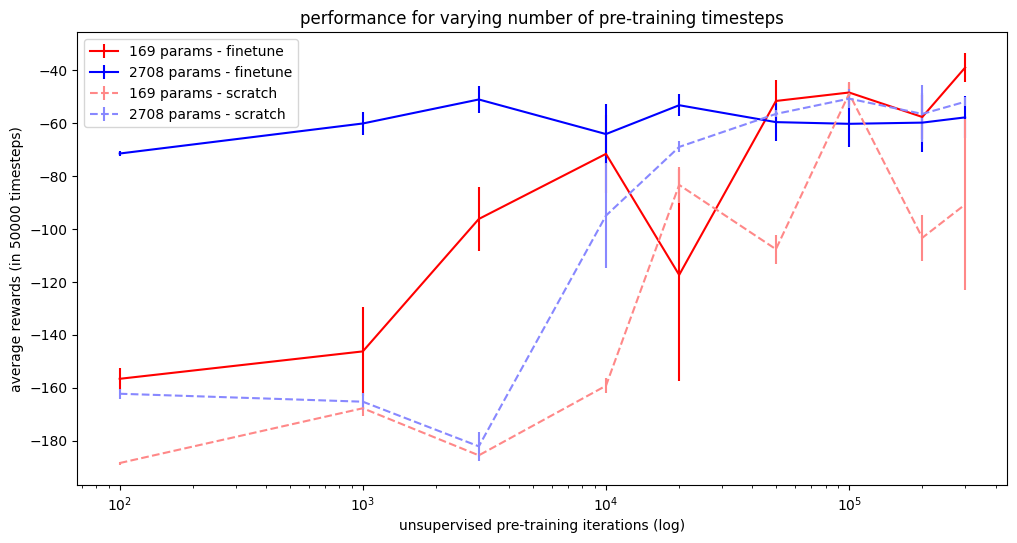

In [34]:
all_rewards = {}
iters = [1e2, 1e3, 3e3, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5]
for i in iters:
    with open('../storage/30-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
        rewards = pickle.load(f)

        for key, val in rewards.items():
            if('169' in key):
                all_rewards[str(int(i))+'-169'] = val
            elif('2708' in key):
                all_rewards[str(int(i))+'-2708'] = val
            else:
                raise
                
all_rewards2 = {}
iters = [1e2, 1e3, 3e3, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5]
for i in iters:
    with open('../storage/28-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
        rewards = pickle.load(f)

        for key, val in rewards.items():
            if('169' in key):
                all_rewards2[str(int(i))+'-169'] = val
            elif('2708' in key):
                all_rewards2[str(int(i))+'-2708'] = val
            else:
                raise

plt.figure(figsize=(12,6),dpi=100)
clip = 50000
smooth = 1000
line1 = []
line1_std = []
line2 = []
line2_std = []
for j, (k, v) in enumerate(all_rewards2.items()):
    ind = k.split('-')
    r_vec = np.zeros((len(v[0]), 50000-smooth+1))
    for i, (t, r) in enumerate(zip(v[0], v[1])):
        r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)

    mean = np.mean(np.array(r_vec), axis=1)
    std = np.std(mean)
    if(ind[1]=='169'):
        line1.append(mean)
        line1_std.append(std)
    if(ind[1]=='2708'):
        line2.append(mean)
        line2_std.append(std)

line1 = np.array(line1)
line2 = np.array(line2)
# import pdb;pdb.set_trace()
plt.errorbar(iters, np.mean(line1,axis=1), line1_std, c='#ff0000',label='169 params - finetune')
plt.errorbar(iters, np.mean(line2,axis=1), line2_std, c='#0000ff', label='2708 params - finetune')
# for i in range(line1.shape[1]):
#     plt.scatter(iters, line1[:,i], c='#ff0000', alpha=0.3)
#     plt.scatter(iters, line2[:,i], c='#0000ff', alpha=0.3)
    
line1 = []
line1_std = []
line2 = []
line2_std = []
for j, (k, v) in enumerate(all_rewards.items()):
    ind = k.split('-')
    r_vec = np.zeros((len(v[0]), 50000-smooth+1))
    for i, (t, r) in enumerate(zip(v[0], v[1])):
        r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)

    mean = np.mean(np.array(r_vec), axis=1)
    std = np.std(mean)
    if(ind[1]=='169'):
        line1.append(mean)
        line1_std.append(std)
    if(ind[1]=='2708'):
        line2.append(mean)
        line2_std.append(std)

line1 = np.array(line1)
line2 = np.array(line2)
# import pdb;pdb.set_trace()
plt.errorbar(iters, np.mean(line1,axis=1), line1_std, c='#ff8888',fmt='--', label='169 params - scratch')
plt.errorbar(iters, np.mean(line2,axis=1), line2_std, c='#8888ff',fmt='--',label='2708 params - scratch')
# for i in range(line1.shape[1]):
#     plt.scatter(iters, line1[:,i], c='#ff0000', alpha=0.3)
#     plt.scatter(iters, line2[:,i], c='#0000ff', alpha=0.3)

plt.xscale('log')
plt.xlabel('unsupervised pre-training iterations (log)'), plt.ylabel('average rewards (in 50000 timesteps)')
plt.title('performance for varying number of pre-training timesteps')
plt.legend(), plt.savefig("../storage/context-speed.png")
plt.show()